#Models

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1236/1236 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 282500352.0000 - mae: 3840.8306 - val_loss: 285682944.0000 - val_mae: 3803.7046
Epoch 2/50
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 316743008.0000 - mae: 3964.4451 - val_loss: 275057760.0000 - val_mae: 3999.2981
Epoch 3/50
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 255041392.0000 - mae: 4040.3901 - val_loss: 271631872.0000 - val_mae: 4878.3828
Epoch 4/50
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 262794496.0000 - mae: 4142.7349 - val_loss: 272353408.0000 - val_mae: 4139.7974
Epoch 5/50
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 256070048.0000 - mae: 4122.7520 - val_loss: 269120832.0000 - val_mae: 4335.8047
Epoch 6/50
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 239817488.0000 - mae: 4200.0791 - val_loss: 268722528.0000 - val_mae: 4279.7065
Epoch 7/50
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 264895248.0000 - mae: 4231.1836 - val_loss: 270747968.0000 - val_mae: 3915.5510
Epo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


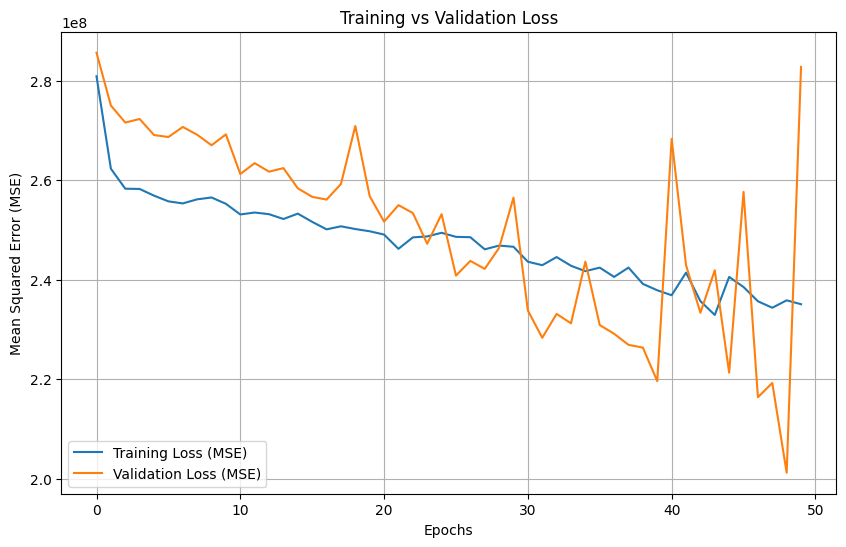

In [ ]:
# Install required libraries (if not already installed)
!pip install tensorflow
!pip install pandas
!pip install scikit-learn

# Import necessary libraries
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv('clustered_data_new.csv')

# Data Preprocessing

# **Step 1: Fill NAs**

def fill_NAs(df):
    df_cleaned = df.copy()

    # Group by 'Item_Code' and 'Market_Name' and calculate the average 'Count_Week_Instock'
    average_count_week_instock = df_cleaned.groupby(['Item_Code', 'Market_Name'])['Count_Week_Instock'].transform('mean')
    # Replace NaN values in 'Count_Week_Instock' with the calculated average
    df_cleaned['Count_Week_Instock'] = df_cleaned['Count_Week_Instock'].fillna(average_count_week_instock)

    # Fill 'Market_Sales_L52wk' with the mean per 'Item_Code'
    df_cleaned['Market_Sales_L52wk'] = df_cleaned.groupby(['Item_Code'])['Market_Sales_L52wk'].transform(
        lambda x: x.fillna(x.mean()))

    # If still NaN, fill with overall mean of 'Normalized_Sales_$L52W' per 'Item_Code'
    df_cleaned['Market_Sales_L52wk'] = df_cleaned['Market_Sales_L52wk'].fillna(
        df_cleaned.groupby(['Item_Code'])['Normalized_Sales_$L52W'].transform('mean'))

    return df_cleaned

df_cleaned = fill_NAs(df)

# **Step 2: Create log-transformed columns**

columns_to_log = [ 'Retail_Price', 'Households', 'Store_Age_Days',
                   'Normalized_Sales_$L52W', 'Market_Sales_L52wk']

for column in columns_to_log:
    # Add a small constant to avoid taking the log of zero
    df_cleaned['log_' + column] = np.log(df_cleaned[column] + 1e-6)

# **Step 3: Create 'Net_Worth_Category'**

# Define the bins for Average Net Worth
bins = [df_cleaned["Average_Net_Worth"].min(), df_cleaned["Average_Net_Worth"].quantile(0.25), df_cleaned["Average_Net_Worth"].quantile(0.5), df_cleaned["Average_Net_Worth"].quantile(0.75), df_cleaned["Average_Net_Worth"].max()]
labels = ['Low', 'Medium', 'High', 'Very High']

df_cleaned['Net_Worth_Category'] = pd.cut(df_cleaned['Average_Net_Worth'], bins=bins, labels=labels, include_lowest=True)

# **Step 4: Create 'Spirits_Direct' column**

# List of Total Wine Partners
total_wine_partners = [
    "Tower Vodka", "Summum Vodka", "Hope Vodka", "Purity Vodka Connoisseur 51", "Classic Club Vodka",
    "The American Plains Vodka", "Froggy B Vodka", "Roberto Cavalli Vodka", "Akva Organic Swedish Vodka",
    "Gallant Vodka", "Opulent Vodka", "Veil Vodka", "Starr Blu Vodka", "Lyna Vodka", "Karkov Vodka",
    "Prairie Organic Vodka", "Pau Maui Handcrafted Vodka", "Eight Degrees Vodka", "Esme Black Shield Vodka",
    "Greenhouse Organic Vodka", "ABK6 Organic Vodka", "Ivanhalder's 1815 Vodka", "Stateside Urbancraft Vodka",
    "3 Howls Blood Orange Vodka"
]

df_cleaned['Spirits_Direct'] = df_cleaned['Item_Name'].apply(
    lambda x: 1 if any(partner.lower() in str(x).lower() for partner in total_wine_partners) else 0
)

# **Step 5: Create 'Flavored_Vodka' column**

# List of flavor keywords
flavor_keywords = [
    'apple', 'apricot', 'berry', 'blackberry', 'blueberry', 'cherry', 'citrus', 'coconut', 'cranberry',
    'grape', 'grapefruit', 'lemon', 'lime', 'mango', 'melon', 'orange', 'peach', 'pear', 'pineapple',
    'raspberry', 'strawberry', 'vanilla', 'watermelon', 'pepper', 'chocolate', 'espresso', 'coffee',
    'caramel', 'honey', 'cinnamon', 'peppermint', 'whipped', 'cake', 'marshmallow', 'butterscotch',
    'ginger', 'pomegranate', 'cucumber', 'mint', 'chai', 'matcha', 'mocha', 'hazelnut', 'almond',
    'gingerbread', 'pumpkin', 'maple', 'smoked', 'herb', 'botanical', 'infusion', 'spice'
]

def is_flavored_vodka(item_name):
    return any(keyword in str(item_name).lower() for keyword in flavor_keywords)

df_cleaned['Flavored_Vodka'] = df_cleaned['Item_Name'].apply(is_flavored_vodka).astype(int)

# **Step 6: Create 'Top20_Vodka' column**

# List of top 20 vodka brands
brand_keywords = [
    'smirnoff', 'absolut', 'zubrowka', 'magic moments', 'arkhangelskaya', 'zoladkowa', 'grey goose', 'soplica', 'pyat ozer',
    'nemiroff', 'belenkaya', 'skyy', 'talka', 'ketel one', 'finlandia', 'russian standard', 'wodka gorbatschow', 'tsarskaya',
    'imperial collection gold', 'green mark', 'belaya bereza'
]

def is_top20_vodka(item_name):
    return any(keyword in str(item_name).lower() for keyword in brand_keywords)

df_cleaned['Top20_Vodka'] = df_cleaned['Item_Name'].apply(is_top20_vodka).astype(int)

# **Step 7: Create ratio variables**

# Ensure the columns are available
columns_to_engineer = [
    'US Whiskey', 'Tequila Under $65', 'Tequila Over $65',
    'Scotch Under $75', 'Scotch Over $75', 'Vodka', 'Cordials',
    'Brandy Under $85', 'Brandy Over $85', 'Cabernet Under $20', 'Cabernet $20-50', 'Cabernet Over $50', 'Chardonnay Under $20', 'Chardonnay Over $20', 'Wine - Sparkling', 'Pinot Noir Under $20', 'Pinot Noir Over $20', 'Sauvignon Blanc', 'French Champagne'
]

for col in columns_to_engineer:
    if col in df_cleaned.columns:
        df_cleaned[f'{col}_engineered'] = df_cleaned[col] + 1  # Adding 1 to avoid division by zero
    else:
        df_cleaned[f'{col}_engineered'] = 1  # If the column doesn't exist, use 1

df_cleaned['Vodka_engineered'] = df_cleaned['Vodka'] + 1  # Ensure 'Vodka_engineered' exists

df_cleaned['Vodka_Tequila_Under_65_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Tequila Under $65_engineered']
df_cleaned['Vodka_Tequila_Over_65_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Tequila Over $65_engineered']

# Calculate the average wine value
wine_columns = [
    'Cabernet Under $20_engineered', 'Cabernet $20-50_engineered', 'Cabernet Over $50_engineered',
    'Chardonnay Under $20_engineered', 'Chardonnay Over $20_engineered', 'Wine - Sparkling_engineered',
    'Pinot Noir Under $20_engineered', 'Pinot Noir Over $20_engineered', 'Sauvignon Blanc_engineered',
    'French Champagne_engineered'
]

df_cleaned['Average_Wine_Value'] = df_cleaned[wine_columns].mean(axis=1)

# Create 'Vodka_Wine_Ratio' variable
df_cleaned['Vodka_Wine_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Average_Wine_Value']

# **Step 8: Proceed with Model Training**

# Split the data into 'data' and 'pred' based on 'Sales Bucket'
data = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales included']
pred = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales excluded for model test']

# Define the features and target for 'data'
X = data[['Vodka', 'Store_Size_Extra Large',
          'Store_Size_Large', 'Store_Size_Medium', 'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA',
          'Store_State_CO', 'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
          'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY', 'Store_State_LA',
          'Store_State_MA', 'Store_State_MD', 'Store_State_MI', 'Store_State_MN', 'Store_State_MO',
          'Store_State_NJ', 'Store_State_NM', 'Store_State_NV', 'Store_State_NY', 'Store_State_SC',
          'Store_State_TN', 'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
          'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml', 'Package_Type_1L',
          'Package_Type_200-3gft', 'Package_Type_200ml', 'Package_Type_375ml', 'Package_Type_700ml',
          'Package_Type_720ml', 'Package_Type_750gft', 'Package_Type_750ml', 'Count_Week_Instock_Normalized',
          'log_Retail_Price', 'log_Households', 'log_Store_Age_Days', 'Cluster_Label',
          'Vodka_Tequila_Under_65_Ratio', 'Vodka_Tequila_Over_65_Ratio', 'Vodka_Wine_Ratio',
          'Spirits_Direct', 'Flavored_Vodka', 'Top20_Vodka']]
y = data['Normalized_Sales_$L52W']

# Proceed with splitting the data, preprocessing, and model training

# Split into train, validation, and holdout sets
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Preprocessing pipeline
numerical_features = ['Vodka', 'Count_Week_Instock_Normalized', 'log_Retail_Price',
                      'log_Households', 'log_Store_Age_Days', 'Vodka_Tequila_Under_65_Ratio',
                      'Vodka_Tequila_Over_65_Ratio', 'Vodka_Wine_Ratio']
categorical_features = ['Store_Size_Extra Large', 'Store_Size_Large', 'Store_Size_Medium',
                        'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA', 'Store_State_CO',
                        'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
                        'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY',
                        'Store_State_LA', 'Store_State_MA', 'Store_State_MD', 'Store_State_MI',
                        'Store_State_MN', 'Store_State_MO', 'Store_State_NJ', 'Store_State_NM',
                        'Store_State_NV', 'Store_State_NY', 'Store_State_SC', 'Store_State_TN',
                        'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
                        'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml',
                        'Package_Type_1L', 'Package_Type_200-3gft', 'Package_Type_200ml',
                        'Package_Type_375ml', 'Package_Type_700ml', 'Package_Type_720ml',
                        'Package_Type_750gft', 'Package_Type_750ml', 'Cluster_Label',
                        'Spirits_Direct', 'Flavored_Vodka', 'Top20_Vodka']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)  # Since categorical features are already binary indicators
    ])

# Preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_holdout_preprocessed = preprocessor.transform(X_holdout)

# Reshape data for CNN input
X_train_preprocessed = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], X_train_preprocessed.shape[1], 1))
X_val_preprocessed = X_val_preprocessed.reshape((X_val_preprocessed.shape[0], X_val_preprocessed.shape[1], 1))
X_holdout_preprocessed = X_holdout_preprocessed.reshape((X_holdout_preprocessed.shape[0], X_holdout_preprocessed.shape[1], 1))

# Define the neural network model with CNN layers
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_preprocessed.shape[1], 1)),
    Dropout(0.3),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_preprocessed, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_preprocessed, y_val),
    verbose=1
)

# Evaluate the model
y_train_pred_nn = model.predict(X_train_preprocessed).flatten()
y_val_pred_nn = model.predict(X_val_preprocessed).flatten()
y_holdout_pred_nn = model.predict(X_holdout_preprocessed).flatten()

# Metrics
def evaluate_model_nn(y_true, y_pred, set_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{set_name} RMSE: {rmse:.4f}")
    print(f"{set_name} MAE: {mae:.4f}")
    print(f"{set_name} R²: {r2:.4f}")

print("Neural Network Model Performance with CNN layers:")
evaluate_model_nn(y_train, y_train_pred_nn, "Training")
evaluate_model_nn(y_val, y_val_pred_nn, "Validation")
evaluate_model_nn(y_holdout, y_holdout_pred_nn, "Holdout")

# Plot training vs validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 65s 48ms/step - loss: 297981120.0000 - mae: 3949.6885 - val_loss: 307335168.0000 - val_mae: 3759.9060
Epoch 2/200
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - loss: 250378496.0000 - mae: 3512.5029 - val_loss: 290066784.0000 - val_mae: 3946.6602
Epoch 3/200
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - loss: 364824032.0000 - mae: 3858.5471 - val_loss: 284554432.0000 - val_mae: 3912.9456
Epoch 4/200
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 80s 44ms/step - loss: 258353776.0000 - mae: 3909.1650 - val_loss: 278547584.0000 - val_mae: 4266.3101
Epoch 5/200
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 86s 47ms/step - loss: 220023280.0000 - mae: 4032.7568 - val_loss: 276413984.0000 - val_mae: 4353.9619
Epoch 6/200
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 59s 48ms/step - loss: 250000144.0000 - mae: 4168.3799 - val_loss: 276415424.0000 - val_mae: 4219.7729
Epoch 7/200
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 84s 50ms/step - loss: 222769168.0000 - mae: 4155.7070 - val_loss: 274179680.0000 - val_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


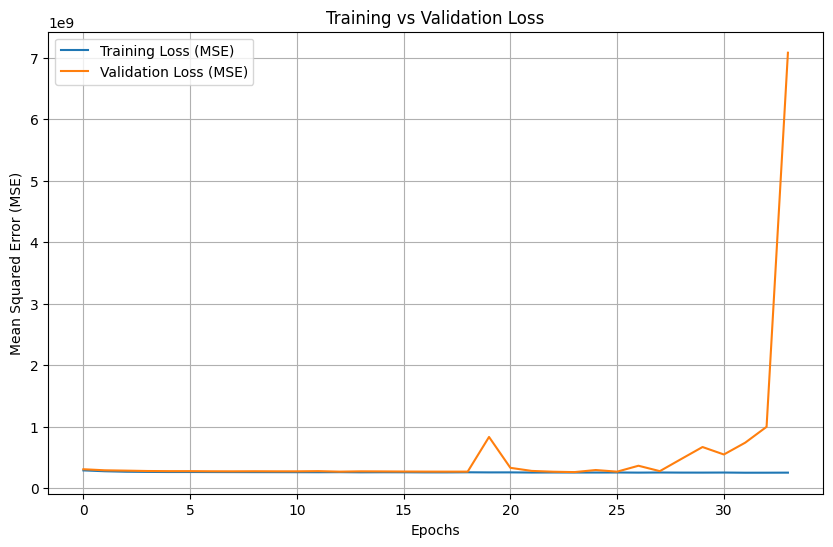

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv('clustered_data_new.csv')

# Data Preprocessing
def fill_NAs(df):
    df_cleaned = df.copy()

    # Group by 'Item_Code' and 'Market_Name' and calculate the average 'Count_Week_Instock'
    average_count_week_instock = df_cleaned.groupby(['Item_Code', 'Market_Name'])['Count_Week_Instock'].transform('mean')
    # Replace NaN values in 'Count_Week_Instock' with the calculated average
    df_cleaned['Count_Week_Instock'] = df_cleaned['Count_Week_Instock'].fillna(average_count_week_instock)

    # Fill 'Market_Sales_L52wk' with the mean per 'Item_Code'
    df_cleaned['Market_Sales_L52wk'] = df_cleaned.groupby(['Item_Code'])['Market_Sales_L52wk'].transform(
        lambda x: x.fillna(x.mean()))

    # If still NaN, fill with overall mean of 'Normalized_Sales_$L52W' per 'Item_Code'
    df_cleaned['Market_Sales_L52wk'] = df_cleaned['Market_Sales_L52wk'].fillna(
        df_cleaned.groupby(['Item_Code'])['Normalized_Sales_$L52W'].transform('mean'))

    return df_cleaned

df_cleaned = fill_NAs(df)

# Log-transform certain columns
columns_to_log = ['Retail_Price', 'Households', 'Store_Age_Days',
                  'Normalized_Sales_$L52W', 'Market_Sales_L52wk']

for column in columns_to_log:
    df_cleaned['log_' + column] = np.log(df_cleaned[column] + 1e-6)

# Remove features that cannot be created due to missing base columns

# Split the data into 'data' and 'pred' based on 'Sales Bucket'
data = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales included']
pred = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales excluded for model test']

# Define the features and target for 'data'
X = data[['Vodka', 'Store_Size_Extra Large',
          'Store_Size_Large', 'Store_Size_Medium', 'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA',
          'Store_State_CO', 'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
          'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY', 'Store_State_LA',
          'Store_State_MA', 'Store_State_MD', 'Store_State_MI', 'Store_State_MN', 'Store_State_MO',
          'Store_State_NJ', 'Store_State_NM', 'Store_State_NV', 'Store_State_NY', 'Store_State_SC',
          'Store_State_TN', 'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
          'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml', 'Package_Type_1L',
          'Package_Type_200-3gft', 'Package_Type_200ml', 'Package_Type_375ml', 'Package_Type_700ml',
          'Package_Type_720ml', 'Package_Type_750gft', 'Package_Type_750ml', 'Count_Week_Instock_Normalized',
          'log_Retail_Price', 'log_Households', 'log_Store_Age_Days', 'Cluster_Label'
          ]]
y = data['Normalized_Sales_$L52W']

# Split into train, validation, and holdout sets
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Preprocessing pipeline
numerical_features = ['Vodka', 'Count_Week_Instock_Normalized', 'log_Retail_Price',
                      'log_Households', 'log_Store_Age_Days']

categorical_features = ['Store_Size_Extra Large', 'Store_Size_Large', 'Store_Size_Medium',
                        'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA', 'Store_State_CO',
                        'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
                        'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY',
                        'Store_State_LA', 'Store_State_MA', 'Store_State_MD', 'Store_State_MI',
                        'Store_State_MN', 'Store_State_MO', 'Store_State_NJ', 'Store_State_NM',
                        'Store_State_NV', 'Store_State_NY', 'Store_State_SC', 'Store_State_TN',
                        'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
                        'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml',
                        'Package_Type_1L', 'Package_Type_200-3gft', 'Package_Type_200ml',
                        'Package_Type_375ml', 'Package_Type_700ml', 'Package_Type_720ml',
                        'Package_Type_750gft', 'Package_Type_750ml', 'Cluster_Label']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)  # Since categorical features are already binary indicators
    ])

# Preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_holdout_preprocessed = preprocessor.transform(X_holdout)

# Reshape data for CNN input
X_train_preprocessed = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], X_train_preprocessed.shape[1], 1))
X_val_preprocessed = X_val_preprocessed.reshape((X_val_preprocessed.shape[0], X_val_preprocessed.shape[1], 1))
X_holdout_preprocessed = X_holdout_preprocessed.reshape((X_holdout_preprocessed.shape[0], X_holdout_preprocessed.shape[1], 1))

# Define the neural network model with increased complexity
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train_preprocessed.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Single output for regression
])

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Implement early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_preprocessed, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_preprocessed, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_train_pred_nn = model.predict(X_train_preprocessed).flatten()
y_val_pred_nn = model.predict(X_val_preprocessed).flatten()
y_holdout_pred_nn = model.predict(X_holdout_preprocessed).flatten()

# Metrics
def evaluate_model_nn(y_true, y_pred, set_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{set_name} RMSE: {rmse:.4f}")
    print(f"{set_name} MAE: {mae:.4f}")
    print(f"{set_name} R²: {r2:.4f}")

print("Neural Network Model Performance with CNN layers and Early Stopping:")
evaluate_model_nn(y_train, y_train_pred_nn, "Training")
evaluate_model_nn(y_val, y_val_pred_nn, "Validation")
evaluate_model_nn(y_holdout, y_holdout_pred_nn, "Holdout")

# Plot training vs validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost Model Performance:
Training RMSE: 7970.3739, MAE: 2740.3180, R²: 0.7698
Validation RMSE: 16722.7171, MAE: 3891.8688, R²: 0.0678
Holdout RMSE: 14864.4870, MAE: 3812.9013, R²: 0.3756



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Random Forest Model Performance:
Training RMSE: 10494.2121, MAE: 2720.5524, R²: 0.6010
Validation RMSE: 15694.1119, MAE: 3279.9849, R²: 0.1789
Holdout RMSE: 15027.7581, MAE: 3404.0431, R²: 0.3618



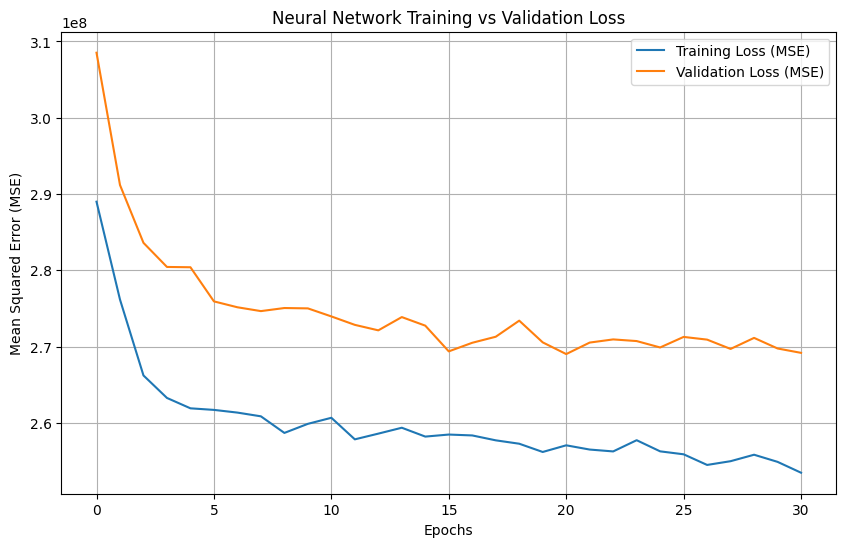

1236/1236 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Neural Network Model Performance:
Training RMSE: 15645.9379, MAE: 4228.2001, R²: 0.1130
Validation RMSE: 16401.5319, MAE: 4443.0304, R²: 0.1032
Holdout RMSE: 17768.5538, MAE: 4528.4292, R²: 0.1078



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [ ]:
# Install required libraries (if not already installed)
!pip install xgboost
!pip install tensorflow
!pip install scikit-learn
!pip install pandas

# Import necessary libraries
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('clustered_data_new.csv')

# Data Preprocessing
def fill_NAs(df):
    df_cleaned = df.copy()

    # Group by 'Item_Code' and 'Market_Name' and calculate the average 'Count_Week_Instock'
    average_count_week_instock = df_cleaned.groupby(['Item_Code', 'Market_Name'])['Count_Week_Instock'].transform('mean')
    # Replace NaN values in 'Count_Week_Instock' with the calculated average
    df_cleaned['Count_Week_Instock'] = df_cleaned['Count_Week_Instock'].fillna(average_count_week_instock)

    # Fill 'Market_Sales_L52wk' with the mean per 'Item_Code'
    df_cleaned['Market_Sales_L52wk'] = df_cleaned.groupby(['Item_Code'])['Market_Sales_L52wk'].transform(
        lambda x: x.fillna(x.mean()))

    # If still NaN, fill with overall mean of 'Normalized_Sales_$L52W' per 'Item_Code'
    df_cleaned['Market_Sales_L52wk'] = df_cleaned['Market_Sales_L52wk'].fillna(
        df_cleaned.groupby(['Item_Code'])['Normalized_Sales_$L52W'].transform('mean'))

    return df_cleaned

df_cleaned = fill_NAs(df)

# Log-transform certain columns
columns_to_log = ['Retail_Price', 'Households', 'Store_Age_Days',
                  'Normalized_Sales_$L52W', 'Market_Sales_L52wk']

for column in columns_to_log:
    df_cleaned['log_' + column] = np.log(df_cleaned[column] + 1e-6)

# Ensure that the necessary columns for ratios are available
required_columns = [
    'Vodka', 'Tequila Under $65', 'Tequila Over $65', 'Cabernet Under $20',
    'Cabernet $20-50', 'Cabernet Over $50', 'Chardonnay Under $20',
    'Chardonnay Over $20', 'Wine - Sparkling', 'Pinot Noir Under $20',
    'Pinot Noir Over $20', 'Sauvignon Blanc', 'French Champagne'
]

missing_columns = [col for col in required_columns if col not in df_cleaned.columns]
if missing_columns:
    print(f"Missing columns for ratio calculations: {missing_columns}")
    # Handle missing columns appropriately (e.g., set them to zero)
    for col in missing_columns:
        df_cleaned[col] = 0

# Create engineered features
columns_to_engineer = required_columns

for col in columns_to_engineer:
    df_cleaned[f'{col}_engineered'] = df_cleaned[col] + 1  # Adding 1 to avoid division by zero

df_cleaned['Vodka_engineered'] = df_cleaned['Vodka'] + 1  # Ensure 'Vodka_engineered' exists

df_cleaned['Vodka_Tequila_Under_65_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Tequila Under $65_engineered']
df_cleaned['Vodka_Tequila_Over_65_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Tequila Over $65_engineered']

# Calculate the average wine value
wine_columns = [
    'Cabernet Under $20_engineered', 'Cabernet $20-50_engineered', 'Cabernet Over $50_engineered',
    'Chardonnay Under $20_engineered', 'Chardonnay Over $20_engineered', 'Wine - Sparkling_engineered',
    'Pinot Noir Under $20_engineered', 'Pinot Noir Over $20_engineered', 'Sauvignon Blanc_engineered',
    'French Champagne_engineered'
]

df_cleaned['Average_Wine_Value'] = df_cleaned[wine_columns].mean(axis=1)

# Create 'Vodka_Wine_Ratio' variable
df_cleaned['Vodka_Wine_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Average_Wine_Value']

# Create additional features 'Spirits_Direct', 'Flavored_Vodka', 'Top20_Vodka'
# For brevity, these steps are omitted, but make sure to include them if they're important.

# Split the data into 'data' and 'pred' based on 'Sales Bucket'
data = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales included']
pred = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales excluded for model test']

# Define the features and target for 'data'
X = data[['Vodka', 'Store_Size_Extra Large',
          'Store_Size_Large', 'Store_Size_Medium', 'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA',
          'Store_State_CO', 'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
          'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY', 'Store_State_LA',
          'Store_State_MA', 'Store_State_MD', 'Store_State_MI', 'Store_State_MN', 'Store_State_MO',
          'Store_State_NJ', 'Store_State_NM', 'Store_State_NV', 'Store_State_NY', 'Store_State_SC',
          'Store_State_TN', 'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
          'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml', 'Package_Type_1L',
          'Package_Type_200-3gft', 'Package_Type_200ml', 'Package_Type_375ml', 'Package_Type_700ml',
          'Package_Type_720ml', 'Package_Type_750gft', 'Package_Type_750ml', 'Count_Week_Instock_Normalized',
          'log_Retail_Price', 'log_Households', 'log_Store_Age_Days', 'Cluster_Label',
          'Vodka_Tequila_Under_65_Ratio', 'Vodka_Tequila_Over_65_Ratio', 'Vodka_Wine_Ratio'
          ]]
y = data['Normalized_Sales_$L52W']

# Split into train, validation, and holdout sets
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)

# Further split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Preprocessing pipeline
numerical_features = ['Vodka', 'Count_Week_Instock_Normalized', 'log_Retail_Price',
                      'log_Households', 'log_Store_Age_Days', 'Vodka_Tequila_Under_65_Ratio',
                      'Vodka_Tequila_Over_65_Ratio', 'Vodka_Wine_Ratio']
categorical_features = ['Store_Size_Extra Large', 'Store_Size_Large', 'Store_Size_Medium',
                        'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA', 'Store_State_CO',
                        'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
                        'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY',
                        'Store_State_LA', 'Store_State_MA', 'Store_State_MD', 'Store_State_MI',
                        'Store_State_MN', 'Store_State_MO', 'Store_State_NJ', 'Store_State_NM',
                        'Store_State_NV', 'Store_State_NY', 'Store_State_SC', 'Store_State_TN',
                        'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
                        'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml',
                        'Package_Type_1L', 'Package_Type_200-3gft', 'Package_Type_200ml',
                        'Package_Type_375ml', 'Package_Type_700ml', 'Package_Type_720ml',
                        'Package_Type_750gft', 'Package_Type_750ml', 'Cluster_Label']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)  # Assuming categorical features are already one-hot encoded
    ])

# Preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_holdout_preprocessed = preprocessor.transform(X_holdout)

# Ensure the preprocessed data is in the correct format
X_train_preprocessed = X_train_preprocessed.astype(np.float32)
X_val_preprocessed = X_val_preprocessed.astype(np.float32)
X_holdout_preprocessed = X_holdout_preprocessed.astype(np.float32)

# Initialize lists to store model predictions
train_predictions = {}
val_predictions = {}
holdout_predictions = {}

# Function to evaluate and store predictions
def evaluate_and_store(model_name, y_train_pred, y_val_pred, y_holdout_pred):
    train_predictions[model_name] = y_train_pred
    val_predictions[model_name] = y_val_pred
    holdout_predictions[model_name] = y_holdout_pred

    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    holdout_rmse = mean_squared_error(y_holdout, y_holdout_pred, squared=False)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    holdout_mae = mean_absolute_error(y_holdout, y_holdout_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    holdout_r2 = r2_score(y_holdout, y_holdout_pred)

    print(f"{model_name} Model Performance:")
    print(f"Training RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.4f}")
    print(f"Holdout RMSE: {holdout_rmse:.4f}, MAE: {holdout_mae:.4f}, R²: {holdout_r2:.4f}\n")

# -----------------------------
# XGBoost Model with Early Stopping
# -----------------------------
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=2424
)

xgb_model.fit(
    X_train_preprocessed, y_train,
    eval_set=[(X_val_preprocessed, y_val)],
    verbose=False
)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train_preprocessed)
y_val_pred_xgb = xgb_model.predict(X_val_preprocessed)
y_holdout_pred_xgb = xgb_model.predict(X_holdout_preprocessed)

# Evaluate and store predictions
evaluate_and_store('XGBoost', y_train_pred_xgb, y_val_pred_xgb, y_holdout_pred_xgb)

# -----------------------------
# Random Forest Model with Cross-Validation
# -----------------------------
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    random_state=2424
)

# Optionally, perform GridSearchCV to tune hyperparameters
# params = {
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10]
# }
# grid_search = GridSearchCV(rf_model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train_preprocessed, y_train)
# rf_model = grid_search.best_estimator_

rf_model.fit(X_train_preprocessed, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_preprocessed)
y_val_pred_rf = rf_model.predict(X_val_preprocessed)
y_holdout_pred_rf = rf_model.predict(X_holdout_preprocessed)

# Evaluate and store predictions
evaluate_and_store('Random Forest', y_train_pred_rf, y_val_pred_rf, y_holdout_pred_rf)

# -----------------------------
# Neural Network with CNN Layers
# -----------------------------
# Reshape data for CNN input
features = X_train_preprocessed.shape[1]

X_train_cnn = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], features, 1))
X_val_cnn = X_val_preprocessed.reshape((X_val_preprocessed.shape[0], features, 1))
X_holdout_cnn = X_holdout_preprocessed.reshape((X_holdout_preprocessed.shape[0], features, 1))

# Define the neural network model with CNN layers
nn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(features, 1)),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
nn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = nn_model.fit(
    X_train_cnn, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    callbacks=[early_stopping],
    verbose=0  # Change to 1 if you want to see the training progress
)

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Neural Network Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predictions
y_train_pred_nn = nn_model.predict(X_train_cnn).flatten()
y_val_pred_nn = nn_model.predict(X_val_cnn).flatten()
y_holdout_pred_nn = nn_model.predict(X_holdout_cnn).flatten()

# Evaluate and store predictions
evaluate_and_store('Neural Network', y_train_pred_nn, y_val_pred_nn, y_holdout_pred_nn)

# -----------------------------
# Ensemble Model using Stacking
# -----------------------------

# Prepare base models
estimators = [
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('nn', nn_model)
]

# Since nn_model is a Keras model, we'll need to create a wrapper to use it in sklearn's StackingRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def create_nn_model():
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(features, 1)),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

nn_estimator = KerasRegressor(build_fn=create_nn_model, epochs=early_stopping.stopped_epoch, batch_size=32, verbose=0)

# Re-train nn_estimator
nn_estimator.fit(X_train_cnn, y_train, validation_data=(X_val_cnn, y_val), callbacks=[early_stopping])

# Update estimators list with the wrapped nn_estimator
estimators = [
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('nn', nn_estimator)
]

# Meta-model
meta_model = LinearRegression()

# Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# Since nn_estimator expects input in CNN format, we need to handle this in the stacking regressor
# We'll create a custom transformer to reshape data for the nn_estimator

from sklearn.base import TransformerMixin, BaseEstimator

class CNNReshaper(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        self.features = X.shape[1]
        return self
    def transform(self, X):
        return X.reshape((X.shape[0], self.features, 1))

# Create a pipeline for the neural network estimator
from sklearn.pipeline import make_pipeline

nn_pipeline = make_pipeline(
    CNNReshaper(),
    nn_estimator
)

# Update estimators with the pipeline
estimators = [
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('nn', nn_pipeline)
]

# Update stacking regressor
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# Train the stacking regressor
stacking_regressor.fit(X_train_preprocessed, y_train)

# Predictions
y_train_pred_ensemble = stacking_regressor.predict(X_train_preprocessed)
y_val_pred_ensemble = stacking_regressor.predict(X_val_preprocessed)
y_holdout_pred_ensemble = stacking_regressor.predict(X_holdout_preprocessed)

# Evaluate ensemble model
evaluate_and_store('Ensemble', y_train_pred_ensemble, y_val_pred_ensemble, y_holdout_pred_ensemble)

# -----------------------------
# Compare Model Performances
# -----------------------------
models = ['XGBoost', 'Random Forest', 'Neural Network', 'Ensemble']

train_rmse_list = []
val_rmse_list = []
holdout_rmse_list = []

for model in models:
    y_train_pred = train_predictions[model]
    y_val_pred = val_predictions[model]
    y_holdout_pred = holdout_predictions[model]

    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    holdout_rmse = mean_squared_error(y_holdout, y_holdout_pred, squared=False)

    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)
    holdout_rmse_list.append(holdout_rmse)

# Plot RMSE comparison
x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, train_rmse_list, width, label='Training RMSE')
plt.bar(x, val_rmse_list, width, label='Validation RMSE')
plt.bar(x + width, holdout_rmse_list, width, label='Holdout RMSE')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Models')
plt.xticks(x, models)
plt.legend()
plt.show()


In [ ]:
# Install required libraries (if not already installed)
!pip install xgboost scikeras tensorflow scikit-learn pandas

# Import necessary libraries
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

import matplotlib.pyplot as plt

# Import KerasRegressor from scikeras
from scikeras.wrappers import KerasRegressor

# Load the dataset
df = pd.read_csv('clustered_data_new.csv')

# Data Preprocessing
def fill_NAs(df):
    df_cleaned = df.copy()

    # Group by 'Item_Code' and 'Market_Name' and calculate the average 'Count_Week_Instock'
    average_count_week_instock = df_cleaned.groupby(['Item_Code', 'Market_Name'])['Count_Week_Instock'].transform('mean')
    # Replace NaN values in 'Count_Week_Instock' with the calculated average
    df_cleaned['Count_Week_Instock'] = df_cleaned['Count_Week_Instock'].fillna(average_count_week_instock)

    # Fill 'Market_Sales_L52wk' with the mean per 'Item_Code'
    df_cleaned['Market_Sales_L52wk'] = df_cleaned.groupby(['Item_Code'])['Market_Sales_L52wk'].transform(
        lambda x: x.fillna(x.mean()))

    # If still NaN, fill with overall mean of 'Normalized_Sales_$L52W' per 'Item_Code'
    df_cleaned['Market_Sales_L52wk'] = df_cleaned['Market_Sales_L52wk'].fillna(
        df_cleaned.groupby(['Item_Code'])['Normalized_Sales_$L52W'].transform('mean'))

    return df_cleaned

df_cleaned = fill_NAs(df)

# Log-transform certain columns
columns_to_log = ['Retail_Price', 'Households', 'Store_Age_Days',
                  'Normalized_Sales_$L52W', 'Market_Sales_L52wk']

for column in columns_to_log:
    df_cleaned['log_' + column] = np.log(df_cleaned[column] + 1e-6)

# Ensure that the necessary columns for ratios are available
required_columns = [
    'Vodka', 'Tequila Under $65', 'Tequila Over $65', 'Cabernet Under $20',
    'Cabernet $20-50', 'Cabernet Over $50', 'Chardonnay Under $20',
    'Chardonnay Over $20', 'Wine - Sparkling', 'Pinot Noir Under $20',
    'Pinot Noir Over $20', 'Sauvignon Blanc', 'French Champagne'
]

missing_columns = [col for col in required_columns if col not in df_cleaned.columns]
if missing_columns:
    print(f"Missing columns for ratio calculations: {missing_columns}")
    # Handle missing columns appropriately (e.g., set them to zero)
    for col in missing_columns:
        df_cleaned[col] = 0

# Create engineered features
columns_to_engineer = required_columns

for col in columns_to_engineer:
    df_cleaned[f'{col}_engineered'] = df_cleaned[col] + 1  # Adding 1 to avoid division by zero

df_cleaned['Vodka_engineered'] = df_cleaned['Vodka'] + 1  # Ensure 'Vodka_engineered' exists

df_cleaned['Vodka_Tequila_Under_65_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Tequila Under $65_engineered']
df_cleaned['Vodka_Tequila_Over_65_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Tequila Over $65_engineered']

# Calculate the average wine value
wine_columns = [
    'Cabernet Under $20_engineered', 'Cabernet $20-50_engineered', 'Cabernet Over $50_engineered',
    'Chardonnay Under $20_engineered', 'Chardonnay Over $20_engineered', 'Wine - Sparkling_engineered',
    'Pinot Noir Under $20_engineered', 'Pinot Noir Over $20_engineered', 'Sauvignon Blanc_engineered',
    'French Champagne_engineered'
]

df_cleaned['Average_Wine_Value'] = df_cleaned[wine_columns].mean(axis=1)

# Create 'Vodka_Wine_Ratio' variable
df_cleaned['Vodka_Wine_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Average_Wine_Value']

# Split the data into 'data' and 'pred' based on 'Sales Bucket'
data = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales included']
pred = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales excluded for model test']

# Define the features and target for 'data'
X = data[['Vodka', 'Store_Size_Extra Large',
          'Store_Size_Large', 'Store_Size_Medium', 'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA',
          'Store_State_CO', 'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
          'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY', 'Store_State_LA',
          'Store_State_MA', 'Store_State_MD', 'Store_State_MI', 'Store_State_MN', 'Store_State_MO',
          'Store_State_NJ', 'Store_State_NM', 'Store_State_NV', 'Store_State_NY', 'Store_State_SC',
          'Store_State_TN', 'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
          'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml', 'Package_Type_1L',
          'Package_Type_200-3gft', 'Package_Type_200ml', 'Package_Type_375ml', 'Package_Type_700ml',
          'Package_Type_720ml', 'Package_Type_750gft', 'Package_Type_750ml', 'Count_Week_Instock_Normalized',
          'log_Retail_Price', 'log_Households', 'log_Store_Age_Days', 'Cluster_Label',
          'Vodka_Tequila_Under_65_Ratio', 'Vodka_Tequila_Over_65_Ratio', 'Vodka_Wine_Ratio'
          ]]
y = data['Normalized_Sales_$L52W']

# Split into train, validation, and holdout sets
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)

# Further split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Preprocessing pipeline
numerical_features = ['Vodka', 'Count_Week_Instock_Normalized', 'log_Retail_Price',
                      'log_Households', 'log_Store_Age_Days', 'Vodka_Tequila_Under_65_Ratio',
                      'Vodka_Tequila_Over_65_Ratio', 'Vodka_Wine_Ratio']
categorical_features = ['Store_Size_Extra Large', 'Store_Size_Large', 'Store_Size_Medium',
                        'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA', 'Store_State_CO',
                        'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
                        'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY',
                        'Store_State_LA', 'Store_State_MA', 'Store_State_MD', 'Store_State_MI',
                        'Store_State_MN', 'Store_State_MO', 'Store_State_NJ', 'Store_State_NM',
                        'Store_State_NV', 'Store_State_NY', 'Store_State_SC', 'Store_State_TN',
                        'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
                        'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml',
                        'Package_Type_1L', 'Package_Type_200-3gft', 'Package_Type_200ml',
                        'Package_Type_375ml', 'Package_Type_700ml', 'Package_Type_720ml',
                        'Package_Type_750gft', 'Package_Type_750ml', 'Cluster_Label']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)  # Assuming categorical features are already one-hot encoded
    ])

# Preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_holdout_preprocessed = preprocessor.transform(X_holdout)

# Ensure the preprocessed data is in the correct format
X_train_preprocessed = X_train_preprocessed.astype(np.float32)
X_val_preprocessed = X_val_preprocessed.astype(np.float32)
X_holdout_preprocessed = X_holdout_preprocessed.astype(np.float32)

# Initialize lists to store model predictions
train_predictions = {}
val_predictions = {}
holdout_predictions = {}

# Function to evaluate and store predictions
def evaluate_and_store(model_name, y_train_pred, y_val_pred, y_holdout_pred):
    train_predictions[model_name] = y_train_pred
    val_predictions[model_name] = y_val_pred
    holdout_predictions[model_name] = y_holdout_pred

    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    holdout_rmse = mean_squared_error(y_holdout, y_holdout_pred, squared=False)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    holdout_mae = mean_absolute_error(y_holdout, y_holdout_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    holdout_r2 = r2_score(y_holdout, y_holdout_pred)

    print(f"{model_name} Model Performance:")
    print(f"Training RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.4f}")
    print(f"Holdout RMSE: {holdout_rmse:.4f}, MAE: {holdout_mae:.4f}, R²: {holdout_r2:.4f}\n")

# -----------------------------
# XGBoost Model with Early Stopping
# -----------------------------
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=2424
)

xgb_model.fit(
    X_train_preprocessed, y_train,
    eval_set=[(X_val_preprocessed, y_val)],

    verbose=False
)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train_preprocessed)
y_val_pred_xgb = xgb_model.predict(X_val_preprocessed)
y_holdout_pred_xgb = xgb_model.predict(X_holdout_preprocessed)

# Evaluate and store predictions
evaluate_and_store('XGBoost', y_train_pred_xgb, y_val_pred_xgb, y_holdout_pred_xgb)

# -----------------------------
# Random Forest Model
# -----------------------------
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    random_state=2424
)

rf_model.fit(X_train_preprocessed, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_preprocessed)
y_val_pred_rf = rf_model.predict(X_val_preprocessed)
y_holdout_pred_rf = rf_model.predict(X_holdout_preprocessed)

# Evaluate and store predictions
evaluate_and_store('Random Forest', y_train_pred_rf, y_val_pred_rf, y_holdout_pred_rf)

# -----------------------------
# Neural Network with CNN Layers
# -----------------------------
# Reshape data for CNN input
features = X_train_preprocessed.shape[1]

X_train_cnn = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], features, 1))
X_val_cnn = X_val_preprocessed.reshape((X_val_preprocessed.shape[0], features, 1))
X_holdout_cnn = X_holdout_preprocessed.reshape((X_holdout_preprocessed.shape[0], features, 1))

# Define the neural network model with CNN layers
def create_nn_model():
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(features, 1)),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Define nn_estimator using scikeras
nn_estimator = KerasRegressor(
    model=create_nn_model,
    epochs=200,
    batch_size=32,
    verbose=0,
    callbacks=[early_stopping]
)

# Fit the nn_estimator
nn_estimator.fit(
    X_train_cnn,
    y_train,
    validation_data=(X_val_cnn, y_val)
)

# Predictions
y_train_pred_nn = nn_estimator.predict(X_train_cnn)
y_val_pred_nn = nn_estimator.predict(X_val_cnn)
y_holdout_pred_nn = nn_estimator.predict(X_holdout_cnn)

# Evaluate and store predictions
evaluate_and_store('Neural Network', y_train_pred_nn, y_val_pred_nn, y_holdout_pred_nn)

# Plot training vs validation loss
history = nn_estimator.history_
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss (MSE)')
plt.plot(history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Neural Network Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Ensemble Model using Stacking
# -----------------------------

# Create CNNReshaper and nn_pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline

class CNNReshaper(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        self.features = X.shape[1]
        return self

    def transform(self, X):
        return X.reshape((X.shape[0], self.features, 1))

nn_pipeline = make_pipeline(
    CNNReshaper(),
    nn_estimator
)

# Prepare base models with nn_pipeline
estimators = [
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('nn', nn_pipeline)
]

# Meta-model
meta_model = LinearRegression()

# Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# Train the stacking regressor
stacking_regressor.fit(X_train_preprocessed, y_train)

# Predictions
y_train_pred_ensemble = stacking_regressor.predict(X_train_preprocessed)
y_val_pred_ensemble = stacking_regressor.predict(X_val_preprocessed)
y_holdout_pred_ensemble = stacking_regressor.predict(X_holdout_preprocessed)

# Evaluate ensemble model
evaluate_and_store('Ensemble', y_train_pred_ensemble, y_val_pred_ensemble, y_holdout_pred_ensemble)

# -----------------------------
# Compare Model Performances
# -----------------------------
models = ['XGBoost', 'Random Forest', 'Neural Network', 'Ensemble']

train_rmse_list = []
val_rmse_list = []
holdout_rmse_list = []

for model in models:
    y_train_pred = train_predictions[model]
    y_val_pred = val_predictions[model]
    y_holdout_pred = holdout_predictions[model]

    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    holdout_rmse = mean_squared_error(y_holdout, y_holdout_pred, squared=False)

    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)
    holdout_rmse_list.append(holdout_rmse)

# Plot RMSE comparison
x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, train_rmse_list, width, label='Training RMSE')
plt.bar(x, val_rmse_list, width, label='Validation RMSE')
plt.bar(x + width, holdout_rmse_list, width, label='Holdout RMSE')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Models')
plt.xticks(x, models)
plt.legend()
plt.show()


Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/requests/__init__.py", line 45, in <module>
    from .exceptions import RequestsDependencyWarning
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/requests/exceptions.py", line 9, in <module>
    from .compat import JSONDecodeError as CompatJSONDecodeError
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/requests/compat.py", line 46, in <module>
    from http import cookiejar as cookielib
  File "/usr/lib/python3.10/http/cookiejar.py", line 212, in <module>
    LOOSE_HTTP_DATE_RE = re.compile(
  File "/usr/lib

Exception ignored in: <function _xla_gc_callback at 0x7de23d1d6a70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost Model Performance:
Training RMSE: 7970.3739, MAE: 2740.3180, R²: 0.7698
Validation RMSE: 16722.7171, MAE: 3891.8688, R²: 0.0678
Holdout RMSE: 14864.4870, MAE: 3812.9013, R²: 0.3756



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Random Forest Model Performance:
Training RMSE: 10494.2121, MAE: 2720.5524, R²: 0.6010
Validation RMSE: 15694.1119, MAE: 3279.9849, R²: 0.1789
Holdout RMSE: 15027.7581, MAE: 3404.0431, R²: 0.3618



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Neural Network Model Performance:
Training RMSE: 16182.1161, MAE: 4020.2785, R²: 0.0512
Validation RMSE: 16241.8727, MAE: 4196.7600, R²: 0.1206
Holdout RMSE: 17625.7220, MAE: 4260.0358, R²: 0.1220



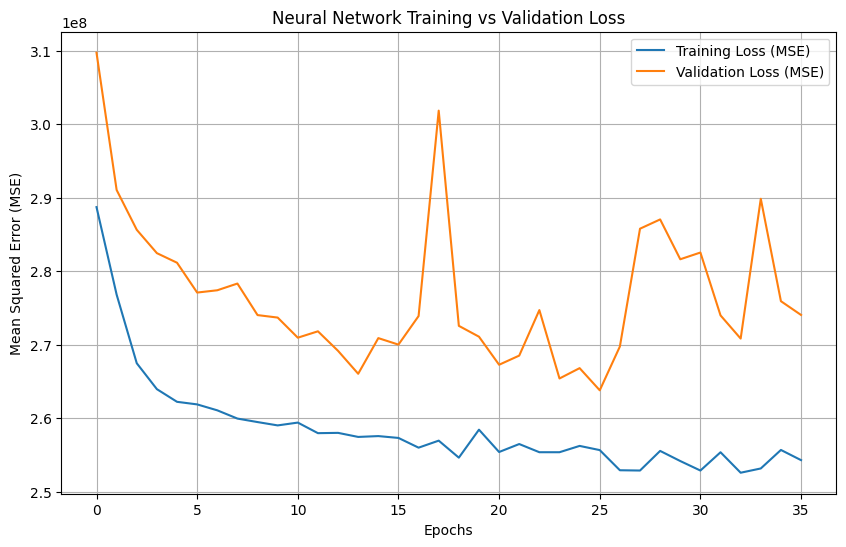

In [ ]:
# Install required libraries (if not already installed)
!pip install xgboost scikeras tensorflow scikit-learn pandas

# Import necessary libraries
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

import matplotlib.pyplot as plt

# Import KerasRegressor from scikeras
from scikeras.wrappers import KerasRegressor

# Load the dataset
df = pd.read_csv('clustered_data_new.csv')

# Data Preprocessing
def fill_NAs(df):
    df_cleaned = df.copy()

    # Group by 'Item_Code' and 'Market_Name' and calculate the average 'Count_Week_Instock'
    average_count_week_instock = df_cleaned.groupby(['Item_Code', 'Market_Name'])['Count_Week_Instock'].transform('mean')
    # Replace NaN values in 'Count_Week_Instock' with the calculated average
    df_cleaned['Count_Week_Instock'] = df_cleaned['Count_Week_Instock'].fillna(average_count_week_instock)

    # Fill 'Market_Sales_L52wk' with the mean per 'Item_Code'
    df_cleaned['Market_Sales_L52wk'] = df_cleaned.groupby(['Item_Code'])['Market_Sales_L52wk'].transform(
        lambda x: x.fillna(x.mean()))

    # If still NaN, fill with overall mean of 'Normalized_Sales_$L52W' per 'Item_Code'
    df_cleaned['Market_Sales_L52wk'] = df_cleaned['Market_Sales_L52wk'].fillna(
        df_cleaned.groupby(['Item_Code'])['Normalized_Sales_$L52W'].transform('mean'))

    return df_cleaned

df_cleaned = fill_NAs(df)

# Log-transform certain columns
columns_to_log = ['Retail_Price', 'Households', 'Store_Age_Days',
                  'Normalized_Sales_$L52W', 'Market_Sales_L52wk']

for column in columns_to_log:
    df_cleaned['log_' + column] = np.log(df_cleaned[column] + 1e-6)

# Ensure that the necessary columns for ratios are available
required_columns = [
    'Vodka', 'Tequila Under $65', 'Tequila Over $65', 'Cabernet Under $20',
    'Cabernet $20-50', 'Cabernet Over $50', 'Chardonnay Under $20',
    'Chardonnay Over $20', 'Wine - Sparkling', 'Pinot Noir Under $20',
    'Pinot Noir Over $20', 'Sauvignon Blanc', 'French Champagne'
]

missing_columns = [col for col in required_columns if col not in df_cleaned.columns]
if missing_columns:
    print(f"Missing columns for ratio calculations: {missing_columns}")
    # Handle missing columns appropriately (e.g., set them to zero)
    for col in missing_columns:
        df_cleaned[col] = 0

# Create engineered features
columns_to_engineer = required_columns

for col in columns_to_engineer:
    df_cleaned[f'{col}_engineered'] = df_cleaned[col] + 1  # Adding 1 to avoid division by zero

df_cleaned['Vodka_engineered'] = df_cleaned['Vodka'] + 1  # Ensure 'Vodka_engineered' exists

df_cleaned['Vodka_Tequila_Under_65_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Tequila Under $65_engineered']
df_cleaned['Vodka_Tequila_Over_65_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Tequila Over $65_engineered']

# Calculate the average wine value
wine_columns = [
    'Cabernet Under $20_engineered', 'Cabernet $20-50_engineered', 'Cabernet Over $50_engineered',
    'Chardonnay Under $20_engineered', 'Chardonnay Over $20_engineered', 'Wine - Sparkling_engineered',
    'Pinot Noir Under $20_engineered', 'Pinot Noir Over $20_engineered', 'Sauvignon Blanc_engineered',
    'French Champagne_engineered'
]

df_cleaned['Average_Wine_Value'] = df_cleaned[wine_columns].mean(axis=1)

# Create 'Vodka_Wine_Ratio' variable
df_cleaned['Vodka_Wine_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Average_Wine_Value']

# Split the data into 'data' and 'pred' based on 'Sales Bucket'
data = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales included']
pred = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales excluded for model test']

# Define the features and target for 'data'
X = data[['Vodka', 'Store_Size_Extra Large',
          'Store_Size_Large', 'Store_Size_Medium', 'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA',
          'Store_State_CO', 'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
          'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY', 'Store_State_LA',
          'Store_State_MA', 'Store_State_MD', 'Store_State_MI', 'Store_State_MN', 'Store_State_MO',
          'Store_State_NJ', 'Store_State_NM', 'Store_State_NV', 'Store_State_NY', 'Store_State_SC',
          'Store_State_TN', 'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
          'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml', 'Package_Type_1L',
          'Package_Type_200-3gft', 'Package_Type_200ml', 'Package_Type_375ml', 'Package_Type_700ml',
          'Package_Type_720ml', 'Package_Type_750gft', 'Package_Type_750ml', 'Count_Week_Instock_Normalized',
          'log_Retail_Price', 'log_Households', 'log_Store_Age_Days', 'Cluster_Label',
          'Vodka_Tequila_Under_65_Ratio', 'Vodka_Tequila_Over_65_Ratio', 'Vodka_Wine_Ratio'
          ]]
y = data['Normalized_Sales_$L52W']

# Split into train, validation, and holdout sets
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)

# Further split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Preprocessing pipeline
numerical_features = ['Vodka', 'Count_Week_Instock_Normalized', 'log_Retail_Price',
                      'log_Households', 'log_Store_Age_Days', 'Vodka_Tequila_Under_65_Ratio',
                      'Vodka_Tequila_Over_65_Ratio', 'Vodka_Wine_Ratio']
categorical_features = ['Store_Size_Extra Large', 'Store_Size_Large', 'Store_Size_Medium',
                        'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA', 'Store_State_CO',
                        'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
                        'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY',
                        'Store_State_LA', 'Store_State_MA', 'Store_State_MD', 'Store_State_MI',
                        'Store_State_MN', 'Store_State_MO', 'Store_State_NJ', 'Store_State_NM',
                        'Store_State_NV', 'Store_State_NY', 'Store_State_SC', 'Store_State_TN',
                        'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
                        'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml',
                        'Package_Type_1L', 'Package_Type_200-3gft', 'Package_Type_200ml',
                        'Package_Type_375ml', 'Package_Type_700ml', 'Package_Type_720ml',
                        'Package_Type_750gft', 'Package_Type_750ml', 'Cluster_Label']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)  # Assuming categorical features are already one-hot encoded
    ])

# Preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_holdout_preprocessed = preprocessor.transform(X_holdout)

# Ensure the preprocessed data is in the correct format
X_train_preprocessed = X_train_preprocessed.astype(np.float32)
X_val_preprocessed = X_val_preprocessed.astype(np.float32)
X_holdout_preprocessed = X_holdout_preprocessed.astype(np.float32)

# Initialize lists to store model predictions
train_predictions = {}
val_predictions = {}
holdout_predictions = {}

# Function to evaluate and store predictions
def evaluate_and_store(model_name, y_train_pred, y_val_pred, y_holdout_pred):
    train_predictions[model_name] = y_train_pred
    val_predictions[model_name] = y_val_pred
    holdout_predictions[model_name] = y_holdout_pred

    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    holdout_rmse = mean_squared_error(y_holdout, y_holdout_pred, squared=False)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    holdout_mae = mean_absolute_error(y_holdout, y_holdout_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    holdout_r2 = r2_score(y_holdout, y_holdout_pred)

    print(f"{model_name} Model Performance:")
    print(f"Training RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.4f}")
    print(f"Holdout RMSE: {holdout_rmse:.4f}, MAE: {holdout_mae:.4f}, R²: {holdout_r2:.4f}\n")

# -----------------------------
# XGBoost Model with Early Stopping
# -----------------------------
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=2424
)

xgb_model.fit(
    X_train_preprocessed, y_train,
    eval_set=[(X_val_preprocessed, y_val)],

    verbose=False
)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train_preprocessed)
y_val_pred_xgb = xgb_model.predict(X_val_preprocessed)
y_holdout_pred_xgb = xgb_model.predict(X_holdout_preprocessed)

# Evaluate and store predictions
evaluate_and_store('XGBoost', y_train_pred_xgb, y_val_pred_xgb, y_holdout_pred_xgb)

# -----------------------------
# Random Forest Model
# -----------------------------
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    random_state=2424
)

rf_model.fit(X_train_preprocessed, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_preprocessed)
y_val_pred_rf = rf_model.predict(X_val_preprocessed)
y_holdout_pred_rf = rf_model.predict(X_holdout_preprocessed)

# Evaluate and store predictions
evaluate_and_store('Random Forest', y_train_pred_rf, y_val_pred_rf, y_holdout_pred_rf)

# -----------------------------
# Neural Network with CNN Layers
# -----------------------------
# Reshape data for CNN input
features = X_train_preprocessed.shape[1]

X_train_cnn = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], features, 1))
X_val_cnn = X_val_preprocessed.reshape((X_val_preprocessed.shape[0], features, 1))
X_holdout_cnn = X_holdout_preprocessed.reshape((X_holdout_preprocessed.shape[0], features, 1))

# Define the neural network model with CNN layers
def create_nn_model():
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(features, 1)),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Define nn_estimator using scikeras
nn_estimator = KerasRegressor(
    model=create_nn_model,
    epochs=200,
    batch_size=32,
    verbose=0,
    callbacks=[early_stopping]
)

# Fit the nn_estimator
nn_estimator.fit(
    X_train_cnn,
    y_train,
    validation_data=(X_val_cnn, y_val)
)

# Predictions
y_train_pred_nn = nn_estimator.predict(X_train_cnn)
y_val_pred_nn = nn_estimator.predict(X_val_cnn)
y_holdout_pred_nn = nn_estimator.predict(X_holdout_cnn)

# Evaluate and store predictions
evaluate_and_store('Neural Network', y_train_pred_nn, y_val_pred_nn, y_holdout_pred_nn)





/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_sto

Ensemble Model Performance:
Training RMSE: 10723.9084, MAE: 2871.5985, R²: 0.5833
Validation RMSE: 15314.2192, MAE: 3401.7977, R²: 0.2182
Holdout RMSE: 15046.2963, MAE: 3503.5099, R²: 0.3602



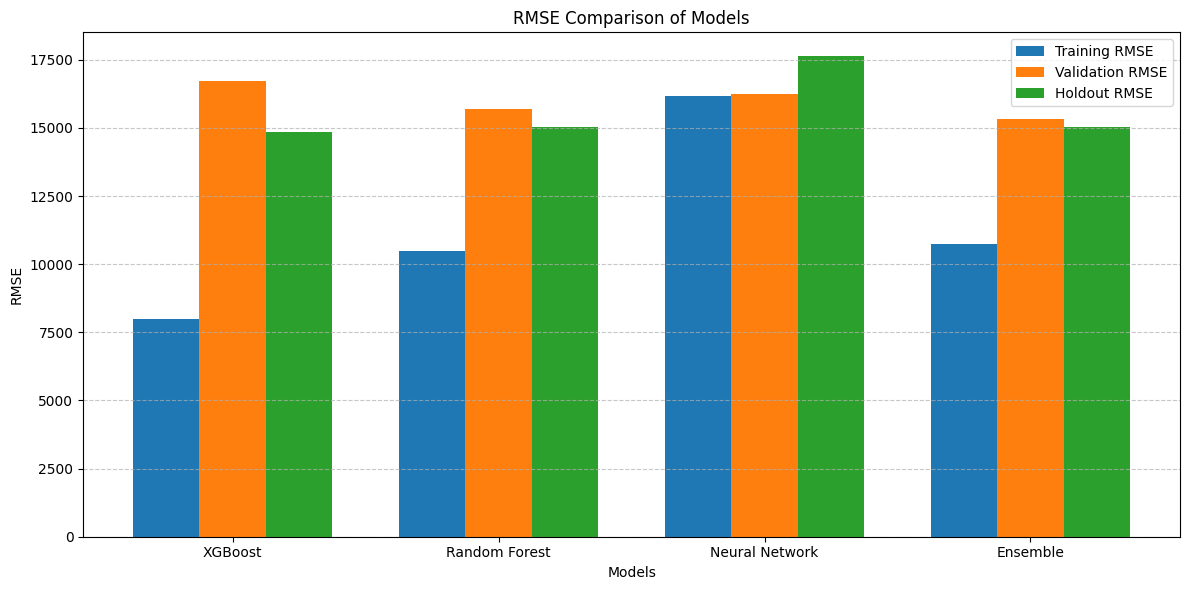

In [ ]:
# -----------------------------
# Ensemble Model with Stacking Regressor
# -----------------------------

# Prepare base models for stacking
base_models = [
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('nn', nn_estimator)
]

# Define the meta-model
meta_model = LinearRegression()

# Create Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True  # Pass original features to meta-model
)

# Fit Stacking Regressor on the training set
stacking_regressor.fit(X_train_preprocessed, y_train)

# Predictions using the ensemble model
y_train_pred_ensemble = stacking_regressor.predict(X_train_preprocessed)
y_val_pred_ensemble = stacking_regressor.predict(X_val_preprocessed)
y_holdout_pred_ensemble = stacking_regressor.predict(X_holdout_preprocessed)

# Evaluate and store ensemble predictions
evaluate_and_store('Ensemble', y_train_pred_ensemble, y_val_pred_ensemble, y_holdout_pred_ensemble)

# -----------------------------
# Performance Comparison
# -----------------------------

# Create a performance comparison DataFrame
performance_metrics = {
    "Model": [],
    "Training RMSE": [],
    "Validation RMSE": [],
    "Holdout RMSE": [],
    "Training MAE": [],
    "Validation MAE": [],
    "Holdout MAE": [],
    "Training R²": [],
    "Validation R²": [],
    "Holdout R²": []
}

models_to_compare = ["XGBoost", "Random Forest", "Neural Network", "Ensemble"]
for model_name in models_to_compare:
    y_train_pred = train_predictions[model_name]
    y_val_pred = val_predictions[model_name]
    y_holdout_pred = holdout_predictions[model_name]

    performance_metrics["Model"].append(model_name)
    performance_metrics["Training RMSE"].append(mean_squared_error(y_train, y_train_pred, squared=False))
    performance_metrics["Validation RMSE"].append(mean_squared_error(y_val, y_val_pred, squared=False))
    performance_metrics["Holdout RMSE"].append(mean_squared_error(y_holdout, y_holdout_pred, squared=False))
    performance_metrics["Training MAE"].append(mean_absolute_error(y_train, y_train_pred))
    performance_metrics["Validation MAE"].append(mean_absolute_error(y_val, y_val_pred))
    performance_metrics["Holdout MAE"].append(mean_absolute_error(y_holdout, y_holdout_pred))
    performance_metrics["Training R²"].append(r2_score(y_train, y_train_pred))
    performance_metrics["Validation R²"].append(r2_score(y_val, y_val_pred))
    performance_metrics["Holdout R²"].append(r2_score(y_holdout, y_holdout_pred))

performance_df = pd.DataFrame(performance_metrics)

# -----------------------------
# RMSE Comparison Bar Plot
# -----------------------------

models = performance_df["Model"].values
train_rmse_list = performance_df["Training RMSE"].values
val_rmse_list = performance_df["Validation RMSE"].values
holdout_rmse_list = performance_df["Holdout RMSE"].values

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, train_rmse_list, width, label='Training RMSE')
plt.bar(x, val_rmse_list, width, label='Validation RMSE')
plt.bar(x + width, holdout_rmse_list, width, label='Holdout RMSE')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Models')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
X.columns

Index(['Vodka', 'Store_Size_Extra Large', 'Store_Size_Large',
       'Store_Size_Medium', 'Store_Size_Small', 'Store_State_AZ',
       'Store_State_CA', 'Store_State_CO', 'Store_State_CT', 'Store_State_DE',
       'Store_State_FL', 'Store_State_GA', 'Store_State_IL', 'Store_State_IN',
       'Store_State_KS', 'Store_State_KY', 'Store_State_LA', 'Store_State_MA',
       'Store_State_MD', 'Store_State_MI', 'Store_State_MN', 'Store_State_MO',
       'Store_State_NJ', 'Store_State_NM', 'Store_State_NV', 'Store_State_NY',
       'Store_State_SC', 'Store_State_TN', 'Store_State_TX', 'Store_State_WA',
       'Store_State_WI', 'Package_Type_1.5L', 'Package_Type_1.75L',
       'Package_Type_1.75Lgft', 'Package_Type_100ml', 'Package_Type_1L',
       'Package_Type_200-3gft', 'Package_Type_200ml', 'Package_Type_375ml',
       'Package_Type_700ml', 'Package_Type_720ml', 'Package_Type_750gft',
       'Package_Type_750ml', 'Count_Week_Instock_Normalized',
       'log_Retail_Price', 'log_Households', 

#Assortment optimization

 Customer Clustering for Store-Specific Assortment

In [ ]:
!pip install xgboost scikeras tensorflow scikit-learn pandas

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

import matplotlib.pyplot as plt

# Import KerasRegressor from scikeras
from scikeras.wrappers import KerasRegressor

# Load the dataset
df = pd.read_csv('clustered_data_new.csv')

# Data Preprocessing
def fill_NAs(df):
    df_cleaned = df.copy()

    # Group by 'Item_Code' and 'Market_Name' and calculate the average 'Count_Week_Instock'
    average_count_week_instock = df_cleaned.groupby(['Item_Code', 'Market_Name'])['Count_Week_Instock'].transform('mean')
    # Replace NaN values in 'Count_Week_Instock' with the calculated average
    df_cleaned['Count_Week_Instock'] = df_cleaned['Count_Week_Instock'].fillna(average_count_week_instock)

    # Fill 'Market_Sales_L52wk' with the mean per 'Item_Code'
    df_cleaned['Market_Sales_L52wk'] = df_cleaned.groupby(['Item_Code'])['Market_Sales_L52wk'].transform(
        lambda x: x.fillna(x.mean()))

    # If still NaN, fill with overall mean of 'Normalized_Sales_$L52W' per 'Item_Code'
    df_cleaned['Market_Sales_L52wk'] = df_cleaned['Market_Sales_L52wk'].fillna(
        df_cleaned.groupby(['Item_Code'])['Normalized_Sales_$L52W'].transform('mean'))

    return df_cleaned

df_cleaned = fill_NAs(df)

# Log-transform certain columns
columns_to_log = ['Retail_Price', 'Households', 'Store_Age_Days',
                  'Normalized_Sales_$L52W', 'Market_Sales_L52wk']

for column in columns_to_log:
    df_cleaned['log_' + column] = np.log(df_cleaned[column] + 1e-6)

# Ensure that the necessary columns for ratios are available
required_columns = [
    'Vodka', 'Tequila Under $65', 'Tequila Over $65', 'Cabernet Under $20',
    'Cabernet $20-50', 'Cabernet Over $50', 'Chardonnay Under $20',
    'Chardonnay Over $20', 'Wine - Sparkling', 'Pinot Noir Under $20',
    'Pinot Noir Over $20', 'Sauvignon Blanc', 'French Champagne'
]

missing_columns = [col for col in required_columns if col not in df_cleaned.columns]
if missing_columns:
    print(f"Missing columns for ratio calculations: {missing_columns}")
    # Handle missing columns appropriately (e.g., set them to zero)
    for col in missing_columns:
        df_cleaned[col] = 0

# Create engineered features
columns_to_engineer = required_columns

for col in columns_to_engineer:
    df_cleaned[f'{col}_engineered'] = df_cleaned[col] + 1  # Adding 1 to avoid division by zero

df_cleaned['Vodka_engineered'] = df_cleaned['Vodka'] + 1  # Ensure 'Vodka_engineered' exists

df_cleaned['Vodka_Tequila_Under_65_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Tequila Under $65_engineered']
df_cleaned['Vodka_Tequila_Over_65_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Tequila Over $65_engineered']

# Calculate the average wine value
wine_columns = [
    'Cabernet Under $20_engineered', 'Cabernet $20-50_engineered', 'Cabernet Over $50_engineered',
    'Chardonnay Under $20_engineered', 'Chardonnay Over $20_engineered', 'Wine - Sparkling_engineered',
    'Pinot Noir Under $20_engineered', 'Pinot Noir Over $20_engineered', 'Sauvignon Blanc_engineered',
    'French Champagne_engineered'
]

df_cleaned['Average_Wine_Value'] = df_cleaned[wine_columns].mean(axis=1)

# Create 'Vodka_Wine_Ratio' variable
df_cleaned['Vodka_Wine_Ratio'] = df_cleaned['Vodka_engineered']/df_cleaned['Average_Wine_Value']

# Split the data into 'data' and 'pred' based on 'Sales Bucket'
data = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales included']
pred = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales excluded for model test']

# Define the features and target for 'data'
X = data[['Vodka', 'Store_Size_Extra Large',
          'Store_Size_Large', 'Store_Size_Medium', 'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA',
          'Store_State_CO', 'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
          'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY', 'Store_State_LA',
          'Store_State_MA', 'Store_State_MD', 'Store_State_MI', 'Store_State_MN', 'Store_State_MO',
          'Store_State_NJ', 'Store_State_NM', 'Store_State_NV', 'Store_State_NY', 'Store_State_SC',
          'Store_State_TN', 'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
          'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml', 'Package_Type_1L',
          'Package_Type_200-3gft', 'Package_Type_200ml', 'Package_Type_375ml', 'Package_Type_700ml',
          'Package_Type_720ml', 'Package_Type_750gft', 'Package_Type_750ml', 'Count_Week_Instock_Normalized',
          'log_Retail_Price', 'log_Households', 'log_Store_Age_Days', 'Cluster_Label',
          'Vodka_Tequila_Under_65_Ratio', 'Vodka_Tequila_Over_65_Ratio', 'Vodka_Wine_Ratio'
          ]]
y = data['Normalized_Sales_$L52W']

# Split into train, validation, and holdout sets
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)

# Further split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Preprocessing pipeline
numerical_features = ['Vodka', 'Count_Week_Instock_Normalized', 'log_Retail_Price',
                      'log_Households', 'log_Store_Age_Days', 'Vodka_Tequila_Under_65_Ratio',
                      'Vodka_Tequila_Over_65_Ratio', 'Vodka_Wine_Ratio']
categorical_features = ['Store_Size_Extra Large', 'Store_Size_Large', 'Store_Size_Medium',
                        'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA', 'Store_State_CO',
                        'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
                        'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY',
                        'Store_State_LA', 'Store_State_MA', 'Store_State_MD', 'Store_State_MI',
                        'Store_State_MN', 'Store_State_MO', 'Store_State_NJ', 'Store_State_NM',
                        'Store_State_NV', 'Store_State_NY', 'Store_State_SC', 'Store_State_TN',
                        'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
                        'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml',
                        'Package_Type_1L', 'Package_Type_200-3gft', 'Package_Type_200ml',
                        'Package_Type_375ml', 'Package_Type_700ml', 'Package_Type_720ml',
                        'Package_Type_750gft', 'Package_Type_750ml', 'Cluster_Label']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)  # Assuming categorical features are already one-hot encoded
    ])

# Preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_holdout_preprocessed = preprocessor.transform(X_holdout)

# Ensure the preprocessed data is in the correct format
X_train_preprocessed = X_train_preprocessed.astype(np.float32)
X_val_preprocessed = X_val_preprocessed.astype(np.float32)
X_holdout_preprocessed = X_holdout_preprocessed.astype(np.float32)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


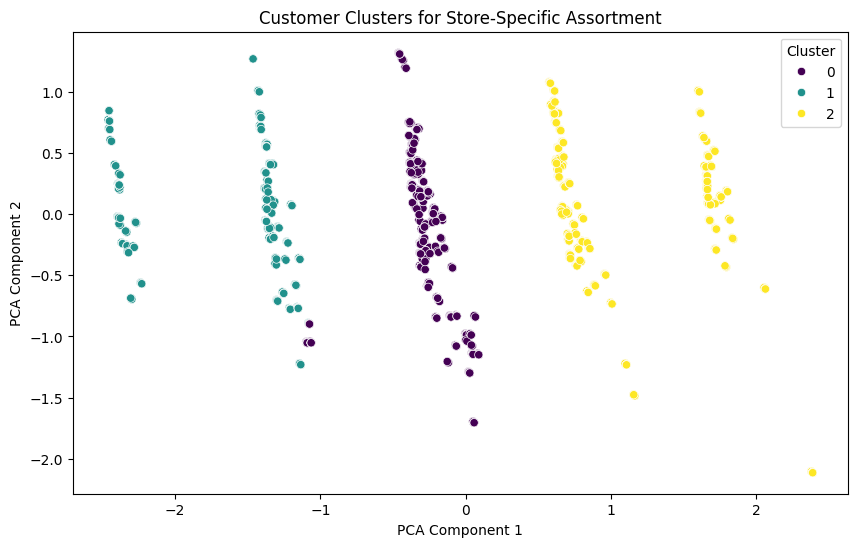

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

# Clustering on demographic and demand-related features
customer_features = ['Vodka', 'log_Households', 'Vodka_Wine_Ratio', 'Count_Week_Instock_Normalized']
X_customer_clustering = X_train[customer_features]

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_customer_clustering)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
customer_clusters = kmeans.fit_predict(X_pca)

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=customer_clusters, palette='viridis')
plt.title('Customer Clusters for Store-Specific Assortment')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Add cluster labels to data for analysis
X_train['Customer_Cluster'] = customer_clusters


1. Axes Explanation:
PCA Component 1 and PCA Component 2:
These are the first two principal components obtained from PCA, which reduce the dimensionality of the original data while retaining most of the variance.
Each point represents a customer or store characterized by the features used in clustering.
2. Clusters (Colored Groups):
Three distinct clusters (denoted by different colors: purple, teal, and yellow) were identified using the K-Means clustering algorithm.
Each cluster groups together customers or stores with similar attributes based on the selected features (e.g., vodka sales, household demographics, etc.).
3. Insights:
Cluster 0 (Purple):
Likely represents a group of customers or stores with unique preferences or sales trends that distinguish them from the other groups.
Could include outliers or niche customer behaviors.
Cluster 1 (Teal):
This is a dense and concentrated cluster, suggesting a group of customers/stores with similar, consistent behavior (e.g., mid-tier vodka preferences).
Cluster 2 (Yellow):
Spread out compared to Cluster 1, indicating more variation in this group. It might represent stores/customers purchasing higher-priced or premium vodka.
4. Use Case for Store-Specific Assortment:
This visualization can help tailor vodka assortments:

Cluster 0: Target specific promotions or products that cater to niche or high-margin items.
Cluster 1: Stock popular, mid-priced vodka brands that meet consistent demand.
Cluster 2: Focus on premium or high-end assortments to maximize sales in this diverse cluster.
Next Steps:
Use this clustering insight to customize assortments for each cluster (e.g., focusing on affordability, variety, or premium selection).
Perform further analysis on feature distributions (e.g., vodka ratios, price categories) within each cluster to refine assortment strategies.

Product Clustering for Bundling Opportunities

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


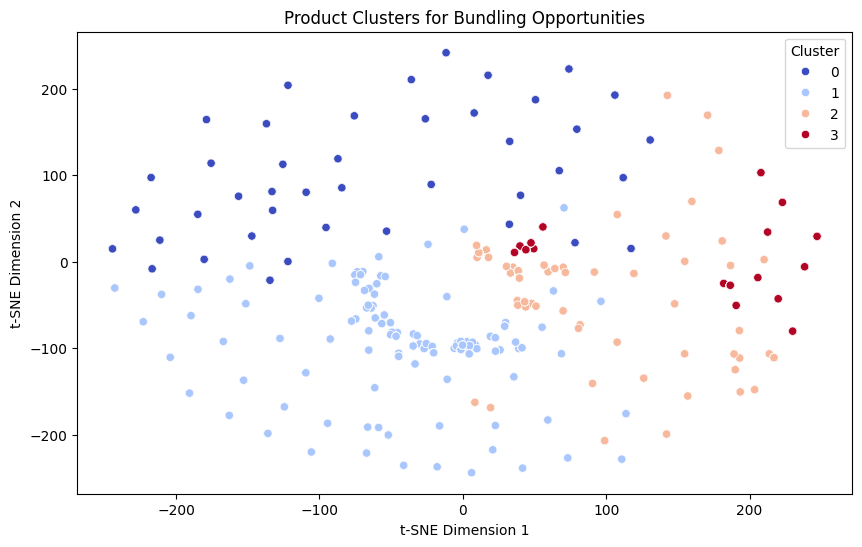

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
# Clustering on product-related attributes
product_features = ['Package_Type_1L', 'Package_Type_750ml', 'Vodka_Tequila_Under_65_Ratio', 'Vodka_Tequila_Over_65_Ratio']
X_product_clustering = X_train[product_features]

# Dimensionality reduction with t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_product_clustering)

# Apply KMeans clustering
kmeans_product = KMeans(n_clusters=4, random_state=42)
product_clusters = kmeans_product.fit_predict(X_product_clustering)

# Visualize Product Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=product_clusters, palette='coolwarm')
plt.title('Product Clusters for Bundling Opportunities')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster')
plt.show()

# Add cluster labels to data for analysis
X_train['Product_Cluster'] = product_clusters


1. Axes Explanation
t-SNE Dimension 1 and t-SNE Dimension 2:
These dimensions are the result of t-SNE, a technique that reduces high-dimensional data into two dimensions for visualization.
While the axes themselves are abstract, the positions represent relative similarities: closer points are more similar in their original feature space (e.g., price, vodka ratios, packaging type).
2. Clusters
Four clusters are identified and represented by different colors (Cluster 0, 1, 2, and 3):

Cluster 0 (Dark Blue):

This group has a wide spread across both dimensions.
Likely represents a diverse range of products with moderate similarities in their feature set.
Bundling Insight: Products in this cluster could work well in general-purpose bundles appealing to a broader audience.
Cluster 1 (Light Blue):

A tightly concentrated group with consistent patterns.
Likely represents products with similar pricing, packaging, or demand characteristics.
Bundling Insight: These products could form cohesive bundles, such as price-based groupings or complementary items.
Cluster 2 (Orange):

Moderately compact but distinct from the other clusters.
Could represent premium or niche products catering to specific customer segments.
Bundling Insight: Ideal for higher-end bundles or limited-edition promotions.
Cluster 3 (Red):

A small, isolated group, indicating unique products that stand apart in the feature space.
Likely includes specialty items or outliers.
Bundling Insight: Focus on promoting these products individually or combining them with popular items from other clusters to drive cross-sales.
3. Observations
Cluster Separation:

The clusters are well-separated, suggesting distinct product groupings based on their attributes.
This clear separation can guide product bundling strategies.
Cluster Characteristics:

The spread within clusters reflects the diversity of products in each group:
Tightly clustered points (Cluster 1) suggest homogeneous products.
Spread-out clusters (Cluster 0) indicate more varied characteristics.
Cluster 3 (Red):

The small size and isolation suggest unique or high-value products requiring special consideration.
4. Use Case for Bundling
Within-Cluster Bundling:
Group products from the same cluster for logical bundles (e.g., similar pricing, demand patterns).
Cross-Cluster Bundling:
Combine products from different clusters to create variety bundles, pairing mainstream products (Cluster 0) with niche or premium items (Cluster 2 or 3).
5. Next Steps
Cluster Analysis:
Examine the specific features of each cluster (e.g., price, vodka ratios, and packaging) to confirm group characteristics.
Pilot Bundling Strategies:
Test cluster-based bundling strategies in stores to assess customer reception and sales performance.
Iterative Refinement:
Use sales data to refine the clustering and bundling strategies over time.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


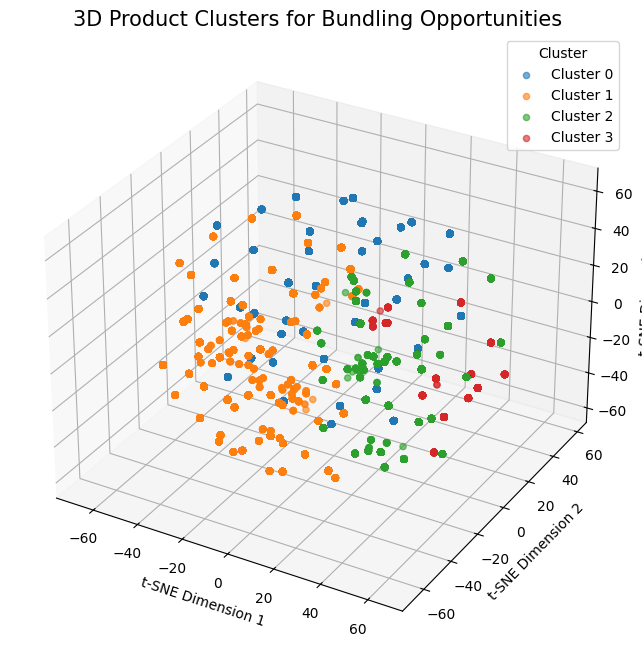

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Clustering on product-related attributes
product_features = ['Package_Type_1L', 'Package_Type_750ml', 'Vodka_Tequila_Under_65_Ratio', 'Vodka_Tequila_Over_65_Ratio']
X_product_clustering = X_train[product_features]

# Dimensionality reduction with t-SNE for 3D visualization
tsne = TSNE(n_components=3, random_state=42)
X_tsne_3d = tsne.fit_transform(X_product_clustering)

# Apply KMeans clustering
kmeans_product = KMeans(n_clusters=4, random_state=42)
product_clusters = kmeans_product.fit_predict(X_product_clustering)

# Visualize Product Clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster in range(4):
    cluster_points = X_tsne_3d[product_clusters == cluster]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster}', alpha=0.6)

# Plot aesthetics
ax.set_title('3D Product Clusters for Bundling Opportunities', fontsize=15)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
ax.legend(title='Cluster')
plt.show()

# Add cluster labels to data for analysis
X_train['Product_Cluster'] = product_clusters


1. Axes Explanation
t-SNE Dimensions (1, 2, and 3):
These axes represent the reduced dimensions generated by the t-SNE algorithm. While the exact meaning of these dimensions is abstract, they capture patterns and relationships between the original product features.
Each point corresponds to a product, and its position is determined based on the similarities in the feature space.
2. Clusters (Colored Groups)
Four clusters (Cluster 0, 1, 2, and 3) are identified and colored distinctly (blue, orange, green, and red).
Products in the same cluster share similar characteristics based on the features used (e.g., packaging type, vodka ratios).
3. Cluster Characteristics
Cluster 0 (Blue):

Widely spread across all dimensions.
Likely represents a diverse group of products with moderate similarity.
Actionable Insight: Products in this cluster might perform well in general bundles for a wide audience.
Cluster 1 (Orange):

Dense and concentrated cluster.
Likely represents a group of products with high similarity in features like price, package type, or vodka ratios.
Actionable Insight: These products can be bundled together as a cohesive set for targeted promotions.
Cluster 2 (Green):

Well-separated but moderately spread cluster.
Could represent high-demand or niche products.
Actionable Insight: These products could be part of premium bundles or paired with complementary items.
Cluster 3 (Red):

A tight, compact cluster with clear distinction from others.
Likely represents unique products with specific attributes.
Actionable Insight: Highlight these products in limited-edition or specialty bundles.
4. Observations from the Plot
The clear separation between clusters indicates that the products can be distinctly grouped based on the input features.
The distribution of points within clusters suggests varying levels of diversity:
Dense clusters (e.g., Cluster 3) imply homogeneity in product features.
Spread-out clusters (e.g., Cluster 0) indicate broader variability.
5. Use Case for Bundling
This clustering can guide bundling strategies:

Within-Cluster Bundling:
Group products within the same cluster for consistent themes (e.g., same price range or vodka type).
Cross-Cluster Bundling:
Combine products from different clusters to offer variety and appeal to a broader audience (e.g., premium products from Cluster 2 with standard items from Cluster 0).
Next Steps
Analyze Cluster Features:
Examine the feature distributions (e.g., Package_Type_1L, Vodka_Tequila_Under_65_Ratio) within each cluster for deeper insights.
Test Bundling Strategies:
Create promotional bundles based on these clusters and test their performance in stores.
Iterative Refinement:
Monitor sales data and adjust clustering parameters or features to refine future bundling opportunities.

Shelf Space Optimization Using Clustering



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


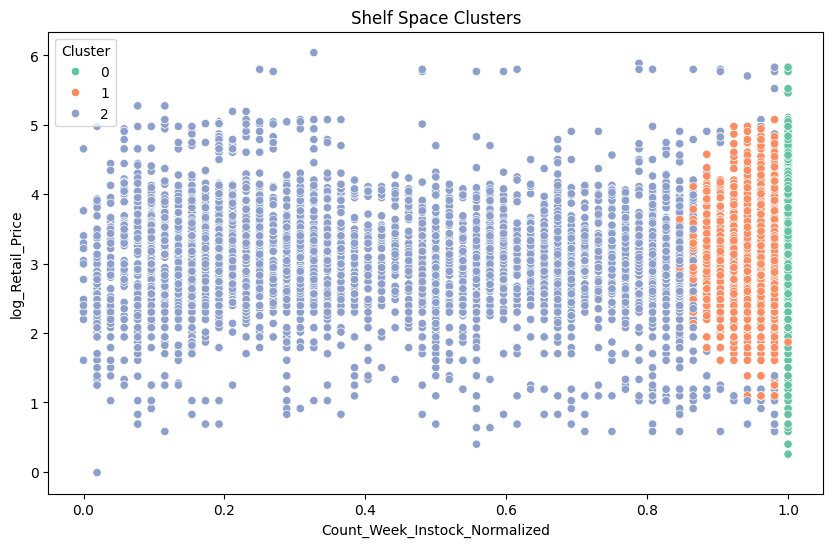

In [ ]:
# Clustering on attributes for shelf space optimization
shelf_features = ['Count_Week_Instock_Normalized', 'log_Retail_Price', 'Vodka_Tequila_Under_65_Ratio']
X_shelf_clustering = X_train[shelf_features]

# Apply Gaussian Mixture Model for flexible clustering
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
shelf_clusters = gmm.fit_predict(X_shelf_clustering)

# Visualize Shelf Space Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_shelf_clustering[shelf_features[0]], y=X_shelf_clustering[shelf_features[1]], hue=shelf_clusters, palette='Set2')
plt.title('Shelf Space Clusters')
plt.xlabel(shelf_features[0])
plt.ylabel(shelf_features[1])
plt.legend(title='Cluster')
plt.show()

# Add cluster labels to data for analysis
X_train['Shelf_Space_Cluster'] = shelf_clusters


1. Axes Explanation
X-Axis (Count_Week_Instock_Normalized):
This represents the normalized count of weeks a product was in stock. Values near 1 indicate products that are consistently available, while values near 0 suggest products with lower availability.
Y-Axis (log_Retail_Price):
This is the logarithmic transformation of the retail price of the product. It scales price variations for better visualization. Higher values correspond to more expensive products, while lower values represent budget-friendly items.
2. Clusters (Colored Groups)
Cluster 0 (Green):

Products with very high Count_Week_Instock_Normalized and moderate log_Retail_Price.
These are highly available products, likely essential or core items in the assortment.
Insight: Allocate prominent shelf space to these items as they are likely staples or top performers.
Cluster 1 (Orange):

Products with high Count_Week_Instock_Normalized but varying log_Retail_Price.
These are readily available products across a price range, including premium and standard items.
Insight: Use these products for dynamic placement strategies, such as positioning premium products at eye level or creating promotional displays.
Cluster 2 (Blue):

Products with varying Count_Week_Instock_Normalized and retail prices.
This is the broadest cluster, encompassing a mix of budget, mid-tier, and premium products with inconsistent availability.
Insight: Focus on optimizing inventory management for this group, ensuring better availability for higher-demand items.
3. Observations
Products with consistent availability (right side of the x-axis) dominate Clusters 0 and 1, suggesting they are prioritized in the assortment.
Cluster 2 contains a significant spread of prices and availability, indicating it includes products with varied demand and stocking patterns.
Few products in the green cluster (Cluster 0) may represent key high-demand products or category leaders that require prominent positioning.
4. Shelf Space Optimization Insights
Cluster 0 (Green):
Prioritize shelf space for these products to ensure easy customer access. They likely drive frequent purchases and overall category traffic.
Cluster 1 (Orange):
Use these products for creative shelf arrangements, such as end caps or special displays, to drive cross-sell opportunities.
Cluster 2 (Blue):
Focus on improving stock consistency for items with high demand and reassess low-performing items to optimize space.
5. Next Steps
Analyze the specific products within each cluster to validate these insights.
Use the cluster assignments to design shelf layouts and monitor the impact on sales and customer satisfaction.
Consider dynamic placement strategies based on product performance within these clusters.

Anomaly Detection for Stocking Optimization

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


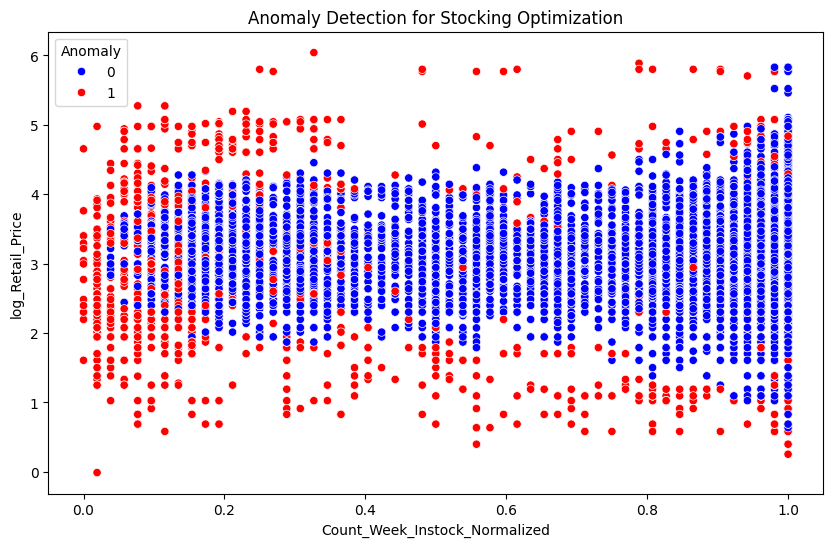

In [ ]:
from sklearn.ensemble import IsolationForest

# Anomaly detection on stock-related features
anomaly_features = ['Count_Week_Instock_Normalized', 'log_Retail_Price', 'Vodka_Wine_Ratio']
X_anomaly_detection = X_train[anomaly_features]

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomalies = iso_forest.fit_predict(X_anomal _detection)

# Mark anomalies
X_train['Anomaly'] = (anomalies == -1).astype(int)

# Visualize anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_anomaly_detection[anomaly_features[0]], y=X_anomaly_detection[anomaly_features[1]], hue=X_train['Anomaly'], palette={0: 'blue', 1: 'red'})
plt.title('Anomaly Detection for Stocking Optimization')
plt.xlabel(anomaly_features[0])
plt.ylabel(anomaly_features[1])
plt.legend(title='Anomaly')
plt.show()


1. Axes Explanation
X-Axis (Count_Week_Instock_Normalized):

Represents the normalized availability of a product in stock over a period of weeks. Values closer to 1 indicate high availability, whereas values closer to 0 suggest lower availability.
Y-Axis (log_Retail_Price):

Represents the logarithmic transformation of the product's retail price. Higher values correspond to premium-priced products, while lower values represent budget products.
2. Legend Explanation
Blue Points (Anomaly = 0):

These are normal products that fit within expected patterns of availability and pricing.
Red Points (Anomaly = 1):

These are anomalous products identified as outliers based on the feature space. These could represent:
Products with unusual stocking patterns (e.g., low availability despite high prices).
Products priced inconsistently with their demand or stocking history.
3. Observations
Normal Products (Blue):

The majority of products fall into this category, showing consistent stocking patterns and pricing.
Anomalous Products (Red):

Spread across various areas in the plot, with two main types:
High Count_Week_Instock_Normalized and High log_Retail_Price:
These may indicate premium products with unusually high availability or low demand.
Low Count_Week_Instock_Normalized and Low log_Retail_Price:
These may represent budget products that are inconsistently stocked or underperforming.
4. Key Insights for Stocking Optimization
High-Priced Anomalies:

For anomalies with high retail prices, investigate whether overstocking is leading to inventory inefficiencies or poor sales performance.
Action: Adjust inventory levels or assess customer demand for these items.
Low-Priced Anomalies:

Low-priced products with low availability could indicate stockouts or poor supply chain management.
Action: Ensure adequate stocking for high-demand budget products.
Mid-Priced, Low Availability:

Products in the mid-price range with low availability may represent missed sales opportunities due to inconsistent stocking.
Action: Prioritize stocking these products based on sales data and customer demand.
5. Next Steps
Investigate Anomalies:
Examine the specific products flagged as anomalies to understand their demand patterns and stocking issues.
Stocking Adjustments:
Use insights from anomalies to optimize stock levels, especially for premium and underperforming products.
Feedback Loop:
Continuously monitor these anomalies over time and refine the detection algorithm based on changes in stocking patterns or market conditions.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


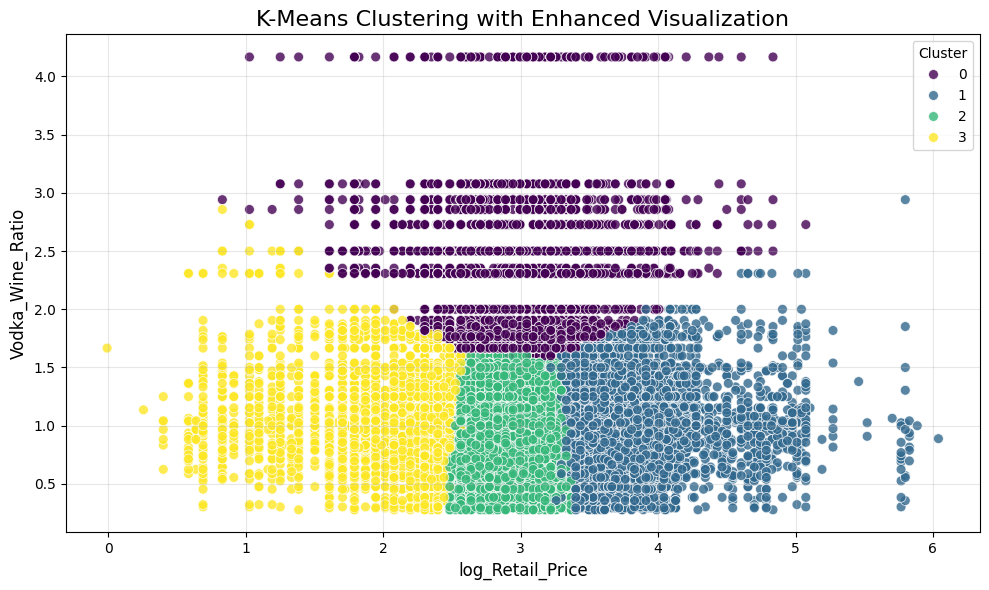

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Features for clustering
features = ['log_Retail_Price', 'Vodka_Wine_Ratio',  'Count_Week_Instock_Normalized']
X_features = pd.DataFrame(X_train, columns=features)  # Ensure compatibility with X_train

# Drop features with all missing values
X_features = X_features.dropna(axis=1, how='all')

# Handle remaining missing values using SimpleImputer (fill NaN with the mean of each column)
imputer = SimpleImputer(strategy='mean')
X_features_imputed = pd.DataFrame(imputer.fit_transform(X_features), columns=X_features.columns)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_features_imputed)

# Add cluster labels to the imputed dataset
X_features_imputed['Cluster'] = clusters





import seaborn as sns
import matplotlib.pyplot as plt

# Enhanced scatter plot with seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_features_imputed['log_Retail_Price'],
    y=X_features_imputed['Vodka_Wine_Ratio'],
    hue=X_features_imputed['Cluster'],
    palette='viridis',
    s=50,  # Adjust marker size
    alpha=0.8  # Adjust transparency
)

# Add plot labels and title
plt.title('K-Means Clustering with Enhanced Visualization', fontsize=16)
plt.xlabel('log_Retail_Price', fontsize=12)
plt.ylabel('Vodka_Wine_Ratio', fontsize=12)
plt.legend(title='Cluster', fontsize=10)
plt.grid(alpha=0.3)  # Add a light grid
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


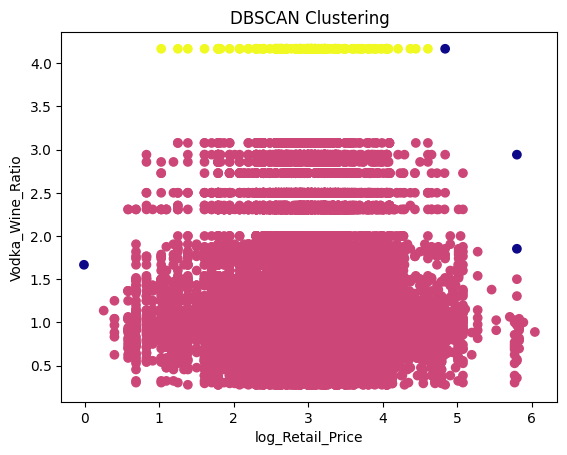

In [ ]:
# 2. DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(X_features)
X_features['DBSCAN_Cluster'] = dbscan_clusters

plt.scatter(X_features['log_Retail_Price'], X_features['Vodka_Wine_Ratio'], c=dbscan_clusters, cmap='plasma')
plt.xlabel('log_Retail_Price')
plt.ylabel('Vodka_Wine_Ratio')
plt.title('DBSCAN Clustering')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Ensure 'Cluster' column is added if not present
if 'Cluster' not in X_features.columns:
    X_features['Cluster'] = clusters

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_features.drop(columns=['Cluster']))

# Visualize t-SNE output
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='coolwarm', alpha=0.8)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Clusters', fontsize=16)
plt.colorbar(label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# 4. PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_features.drop(columns=['Cluster', 'DBSCAN_Cluster']))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Clusters')
plt.show()


